## _*H2 ground state energy computation using Iterative QPE*_

This notebook demonstrates computing and graphing the ground state energy of the Hydrogen (H2) molecule over a range of inter-atomic distances using `IQPE` (Iterative Quantum Phase Estimation) algorithm. It is compared to the ground-truth energies as computed by the `ExactEigensolver`.

This notebook has been written to use the PYSCF chemistry driver. See the PYSCF chemistry driver readme if you need to install the external PySCF library that this driver requires.

First we define the `compute_energy` method, which contains the H2 molecule definition as well as the computation of its ground energy given the desired `distance` and `algorithm` (`i` is just a helper index for parallel computation to speed things up).

In [48]:
import pylab
import time
import numpy as np
import multiprocessing as mp
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance, AquaError
from qiskit.aqua.operators import Z2Symmetries
from qiskit.aqua.operators.op_converter import to_weighted_pauli_operator
from qiskit.aqua.algorithms.single_sample import IQPE
from qiskit.aqua.algorithms.single_sample import QPE
from qiskit.aqua.components.iqfts import Standard
from qiskit.aqua.algorithms.classical import ExactEigensolver
from qiskit.chemistry import FermionicOperator
from qiskit.chemistry.aqua_extensions.components.initial_states import HartreeFock
from qiskit.chemistry.drivers import PySCFDriver, UnitsType

def compute_energy(i, distance, algorithm):
    try:
        driver = PySCFDriver(
            atom='H .0 .0 .0; H .0 .0 {}'.format(distance),
            unit=UnitsType.ANGSTROM,
            charge=0,
            spin=0,
            basis='sto3g'
        )
    except:
        raise AquaError('PYSCF driver does not appear to be installed')
    molecule = driver.run()
    qubit_mapping = 'parity'
    fer_op = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    qubit_op = Z2Symmetries.two_qubit_reduction(to_weighted_pauli_operator(fer_op.mapping(map_type=qubit_mapping, threshold=1e-10)), 2)

    if algorithm.lower() == 'exacteigensolver':
        exact_eigensolver = ExactEigensolver(qubit_op, k=1)
        result = exact_eigensolver.run()
        reference_energy = result['energy']
    elif algorithm.lower() == 'iqpe':
        num_particles = molecule.num_alpha + molecule.num_beta
        two_qubit_reduction = True
        num_orbitals = qubit_op.num_qubits + (2 if two_qubit_reduction else 0)

        num_time_slices = 2
        num_iterations = 10
        state_in = HartreeFock(qubit_op.num_qubits, num_orbitals,
                               num_particles, qubit_mapping, two_qubit_reduction)
        iqpe = IQPE(qubit_op, state_in, num_time_slices, num_iterations,
                    expansion_mode='trotter', expansion_order=1,
                    shallow_circuit_concat=True)
#         backend = BasicAer.get_backend('statevector_simulator')
        backend = BasicAer.get_backend('qasm_simulator')
        quantum_instance = QuantumInstance(backend)

        result = iqpe.run(quantum_instance)
    elif algorithm.lower() == 'qpe':
        num_particles = molecule.num_alpha + molecule.num_beta
        two_qubit_reduction = True
        num_orbitals = qubit_op.num_qubits + (2 if two_qubit_reduction else 0)

        num_time_slices = 10
        iqft = Standard(qubit_op.num_qubits)
        state_in = HartreeFock(qubit_op.num_qubits, num_orbitals,
                               num_particles, qubit_mapping, two_qubit_reduction)
        qpe = QPE(qubit_op, state_in, iqft, num_time_slices, num_ancillae=4,
                   expansion_mode='trotter', expansion_order=1,
                   shallow_circuit_concat=True)
        backend = BasicAer.get_backend('statevector_simulator')
        quantum_instance = QuantumInstance(backend)

        result = qpe.run(quantum_instance)
    else:
        raise AquaError('Unrecognized algorithm.')
    return i, distance, result['energy'] + molecule.nuclear_repulsion_energy, molecule.hf_energy

Next we set up the experiment to compute H2 ground energies for a range of inter-atomic distances, in parallel.

In [31]:
import concurrent.futures
import multiprocessing as mp

algorithms = ['iqpe', 'exacteigensolver', 'qpe']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 1   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

start_time = time.time()
for j in range(len(algorithms)):
    algorithm = algorithms[j]
    print(f'On algorithm {algorithm}')
    for i in range(steps+1):
        d = start + i*by/steps
        result = compute_energy(
            i, 
            d, 
            algorithm
        )
        i, d, energy, hf_energy = result
        energies[j][i] = energy
        hf_energies[i] = hf_energy
        distances[i] = d
        
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

On algorithm iqpe
On algorithm exacteigensolver
On algorithm qpe
 --- complete
Distances:  [0.5 1. ]
Energies: [[-1.04413391 -1.09001944]
 [-1.05515979 -1.10115033]
 [-1.05758266 -1.1041609 ]]
Hartree-Fock energies: [-1.04299627 -1.06610865]
--- 573.7686002254486 seconds ---


Finally we plot the results:

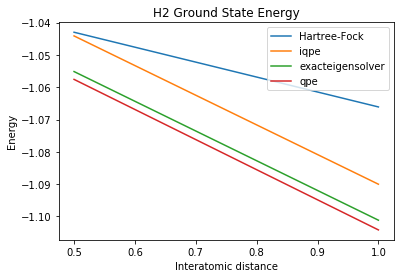

In [33]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')
pylab.show()

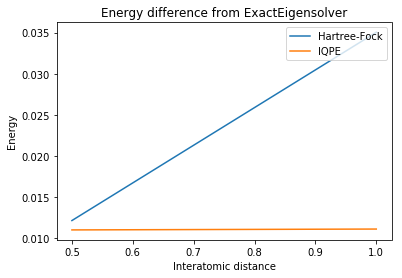

In [13]:
pylab.plot(distances, np.subtract(hf_energies, energies[1]), label='Hartree-Fock')
pylab.plot(distances, np.subtract(energies[0], energies[1]), label='IQPE')
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('Energy difference from ExactEigensolver')
pylab.legend(loc='upper right')
pylab.show()

In [27]:
import concurrent.futures
import multiprocessing as mp

algorithms = ['qpe']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 1   # Number of steps to increase by
reps=5
energies = np.empty([len(algorithms), steps+1, reps])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

start_time = time.time()
for j in range(len(algorithms)):
    for k in range(reps):
        algorithm = algorithms[j]
        print(f'On algorithm {algorithm}')
        for i in range(steps+1):
            d = start + i*by/steps
            result = compute_energy(
                i, 
                d, 
                algorithm
            )
            i, d, energy, hf_energy = result
            energies[j][i][k] = energy
            hf_energies[i] = hf_energy
            distances[i] = d
        
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

On algorithm qpe
On algorithm qpe
On algorithm qpe
On algorithm qpe
On algorithm qpe
 --- complete
Distances:  [0.5 1. ]
Energies: [[[-1.05758266 -1.05758266 -1.05758266 -1.05758266 -1.05758266]
  [-1.1041609  -1.1041609  -1.1041609  -1.1041609  -1.1041609 ]]]
Hartree-Fock energies: [-1.04299627 -1.06610865]
--- 1290.376314163208 seconds ---


In [45]:
from qiskit.chemistry import set_qiskit_chemistry_logging
import logging
set_qiskit_chemistry_logging(logging.INFO)

In [49]:
import concurrent.futures
import multiprocessing as mp

algorithms = ['iqpe', 'exacteigensolver', 'qpe']
start = 0.5  # Start distance
by    = 0.5  # How much to increase distance by
steps = 1   # Number of steps to increase by
energies = np.empty([len(algorithms), steps+1])
hf_energies = np.empty(steps+1)
distances = np.empty(steps+1)

start_time = time.time()
for j in range(len(algorithms)):
    algorithm = algorithms[j]
    print(f'On algorithm {algorithm}')
    for i in range(steps+1):
        d = start + i*by/steps
        result = compute_energy(
            i, 
            d, 
            algorithm
        )
        i, d, energy, hf_energy = result
        energies[j][i] = energy
        hf_energies[i] = hf_energy
        distances[i] = d
        
print(' --- complete')

print('Distances: ', distances)
print('Energies:', energies)
print('Hartree-Fock energies:', hf_energies)

print("--- %s seconds ---" % (time.time() - start_time))

2019-09-12 22:30:32,472:qiskit.chemistry.drivers.pyscfd.integrals:INFO: PySCF kernel() converged: True, e(hf): -1.042996274540095
2019-09-12 22:30:32,474:qiskit.chemistry.drivers.pyscfd.integrals:INFO: HF Electronic dipole moment: [-0.         -0.         -0.94486306]
2019-09-12 22:30:32,475:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Nuclear dipole moment: [0.         0.         0.94486306]
2019-09-12 22:30:32,475:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Total dipole moment: [0. 0. 0.]


On algorithm iqpe


2019-09-12 22:30:32,785:qiskit.chemistry.aqua_extensions.components.initial_states.hartree_fock:INFO: We assume that the number of alphas and betas are the same.
2019-09-12 22:30:32,789:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.9.0
Backend: 'qasm_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1024)
{'timeout': None}
{}
{}
Measurement mitigation: None
2019-09-12 22:30:32,792:qiskit.aqua.operators.common:INFO: Under shallow slicing mode, the qc.data reference is repeated shallowly. Thus, changing gates of one slice of the output circuit might affect other slices.
2019-09-12 22:30:55,129:qiskit.aqua.algorithms.single_sample.iterative_qpe.iqpe:INFO: Reverse iteration 10 of 10 with measured bit 1
2019-09-12 22:30:55,131:qiskit.aqua.operators.common:INFO: Under sha

2019-09-12 22:32:02,600:qiskit.aqua.operators.common:INFO: Under shallow slicing mode, the qc.data reference is repeated shallowly. Thus, changing gates of one slice of the output circuit might affect other slices.
2019-09-12 22:32:02,652:qiskit.aqua.algorithms.single_sample.iterative_qpe.iqpe:INFO: Reverse iteration 1 of 10 with measured bit 0
2019-09-12 22:32:02,893:qiskit.chemistry.drivers.pyscfd.integrals:INFO: PySCF kernel() converged: True, e(hf): -1.042996274540095
2019-09-12 22:32:02,895:qiskit.chemistry.drivers.pyscfd.integrals:INFO: HF Electronic dipole moment: [-0.         -0.         -0.94486306]
2019-09-12 22:32:02,896:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Nuclear dipole moment: [0.         0.         0.94486306]
2019-09-12 22:32:02,896:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Total dipole moment: [0. 0. 0.]


On algorithm exacteigensolver


2019-09-12 22:32:03,457:qiskit.chemistry.drivers.pyscfd.integrals:INFO: PySCF kernel() converged: True, e(hf): -1.0661086493179366
2019-09-12 22:32:03,459:qiskit.chemistry.drivers.pyscfd.integrals:INFO: HF Electronic dipole moment: [-0.         -0.         -1.88972612]
2019-09-12 22:32:03,460:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Nuclear dipole moment: [0.         0.         1.88972612]
2019-09-12 22:32:03,461:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Total dipole moment: [0. 0. 0.]
2019-09-12 22:32:04,016:qiskit.chemistry.drivers.pyscfd.integrals:INFO: PySCF kernel() converged: True, e(hf): -1.042996274540095
2019-09-12 22:32:04,019:qiskit.chemistry.drivers.pyscfd.integrals:INFO: HF Electronic dipole moment: [-0.         -0.         -0.94486306]
2019-09-12 22:32:04,020:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Nuclear dipole moment: [0.         0.         0.94486306]
2019-09-12 22:32:04,020:qiskit.chemistry.drivers.pyscfd.integrals:INFO: Total dipole moment: [0. 

On algorithm qpe


2019-09-12 22:32:04,323:qiskit.chemistry.aqua_extensions.components.initial_states.hartree_fock:INFO: We assume that the number of alphas and betas are the same.
2019-09-12 22:32:04,326:qiskit.aqua.quantum_instance:INFO: statevector backend only works with shot=1, change shots from 1024 to 1.
2019-09-12 22:32:04,328:qiskit.aqua.quantum_instance:INFO: 
Qiskit Terra version: 0.9.0
Backend: 'statevector_simulator (BasicAer)', with following setting:
{'basis_gates': ['u1', 'u2', 'u3', 'cx', 'id', 'unitary'], 'coupling_map': None}
{'pass_manager': None, 'initial_layout': None, 'seed_transpiler': None, 'optimization_level': None}
RunConfig(max_credits=10, shots=1)
{'timeout': None}
{}
{}
Measurement mitigation: None
2019-09-12 22:32:04,331:qiskit.aqua.operators.common:INFO: Under shallow slicing mode, the qc.data reference is repeated shallowly. Thus, changing gates of one slice of the output circuit might affect other slices.
2019-09-12 22:32:04,371:qiskit.aqua.operators.common:INFO: Under 

 --- complete
Distances:  [0.5 1. ]
Energies: [[-1.05309975 -1.09709017]
 [-1.05515979 -1.10115033]
 [-0.94999264 -1.0546658 ]]
Hartree-Fock energies: [-1.04299627 -1.06610865]
--- 99.63679575920105 seconds ---


Finally we plot the results:

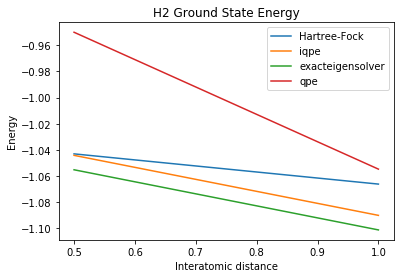

In [47]:
pylab.plot(distances, hf_energies, label='Hartree-Fock')
for j in range(len(algorithms)):
    pylab.plot(distances, energies[j], label=algorithms[j])
pylab.xlabel('Interatomic distance')
pylab.ylabel('Energy')
pylab.title('H2 Ground State Energy')
pylab.legend(loc='upper right')
pylab.show()

In [37]:
BasicAer.backends()

[<QasmSimulatorPy('qasm_simulator') from BasicAer()>,
 <StatevectorSimulatorPy('statevector_simulator') from BasicAer()>,
 <UnitarySimulatorPy('unitary_simulator') from BasicAer()>]